## Implementation of the paper 'Image noise types recognition using convolutional neural network with principal components analysis'

#### doi: 10.1049/iet-ipr.2017.0374
##### Hui Ying Khaw1
##### Foo Chong Soon1
##### Joon Huang Chuah1
##### Chee-Onn Chow1'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

plt.style.use("dark_background")


In [2]:
# Setting up the CNN model based on architecture proposed by paper.

import tensorflow as tf
from tensorflow.keras import layers, models

physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Define the model
model = models.Sequential()

model.add(layers.Input(shape=(64, 64, 1)))

# Convolutional layers
model.add(layers.Conv2D(5, (3, 3),  padding='same'))
model.add(layers.Dropout(0.1)) 

# Max-pooling layers
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Convolutional layers
model.add(layers.Conv2D(50, (8, 8),  padding='same'))
model.add(layers.Dropout(0.1)) 

# Max-pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Flatten the output for the fully connected layer
model.add(layers.Flatten())

# Softmax classifier
model.add(layers.Dense(4, activation='softmax'))
 
# Compile the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 5)         50        
                                                                 
 dropout (Dropout)           (None, 64, 64, 5)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        16050     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 50)       0         
 2D)                                                    

In [3]:
# Types of noise the model will support:
NOISE_TYPE_IMPULSE = 0
NOISE_TYPE_GAUSSIAN = 1
NOISE_TYPE_SPECKLE = 2
NOISE_TYPE_POISSON = 3

# Ranges for noise types
IMPULSE_LOW_PROBABILITY = 0.025
IMPULSE_HIGH_PROBABILITY = 0.06
GAUSSIAN_LOW_SIGMA = 0.5
GAUSSIAN_HIGH_SIGMA = 0.7
SPECKLE_LOW_PROBABILITY = 0.1
SPECKLE_HIGH_PROBABILITY = 0.30
POISSON_LOW_SCALE_FACTOR = 2e+1
POISSON_HIGH_SCALE_FACTOR = 80

In [4]:
0# Add noise to the images (Train images is from LGG dataset)

lgg_dataset_dir = '../../../../Dataset/lgg-mri-segmentation/kaggle_3m'

lgg_training_files = []

for root, folder_name, file_names in os.walk(lgg_dataset_dir):
    for file_name in file_names:
        if "mask" not in file_name:  # Exclude files with 'mask' in their names
            file_path = os.path.join(root, file_name)
            lgg_training_files.append(file_path)
        
print(lgg_training_files[0])

../../../../Dataset/lgg-mri-segmentation/kaggle_3m\data.csv


In [5]:
print('num of images: ', len(lgg_training_files))

num of images:  3931


In [6]:

# Load 4000 images from dataset.

imgs = []

for i in range(2, 3900):
    img = cv2.imread(lgg_training_files[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))

    imgs.append(img)

image shape:  (64, 64)


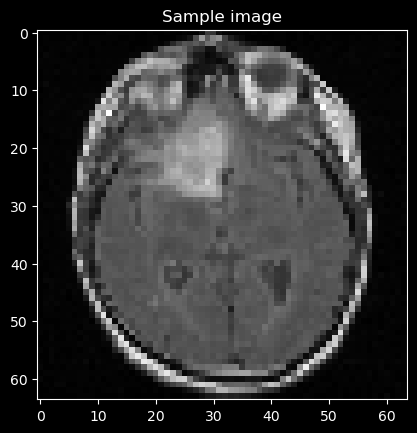

In [7]:

plt.title('Sample image')
plt.imshow(imgs[3], cmap='gray')
print('image shape: ', imgs[3].shape)

In [8]:
# Functions to add noise to image
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)

    # Add salt noise
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    salt_coords = [np.random.randint(0, high=image.shape[0], size=num_salt),
                   np.random.randint(0, high=image.shape[1], size=num_salt)]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    pepper_coords = [np.random.randint(0, high=image.shape[0], size=num_pepper),
                     np.random.randint(0, high=image.shape[1], size=num_pepper)]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

def add_gaussian_noise(image, mean=0, stddev=2):
    noisy_image = image.copy()

    r_mean = np.random.uniform(0, mean)
    r_std =  np.random.uniform(0, stddev)
    
    #print(r_mean, r_std)
    
    noise = np.random.normal(np.random.uniform(0, mean), np.random.uniform(GAUSSIAN_LOW_SIGMA / 2, stddev), image.shape).astype(np.uint8)
    noisy_image = cv2.add(image[:, :], noise)
    
    return noisy_image

def add_speckle_noise(image, stddev=0.1):
    noisy_image = image.copy()
    
    noise = np.random.normal(0, np.random.uniform(0.1, stddev), image.shape)
    noisy_image[:, :] = np.uint8(np.clip(image[:, :] + image[:, :] * noise, 0, 255))
    
    return noisy_image

def add_poisson_noise(image, scale):
    noisy_image = image.copy()

    noise = np.random.poisson(np.random.uniform(POISSON_LOW_SCALE_FACTOR // 2, scale), image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)

    return noisy_image

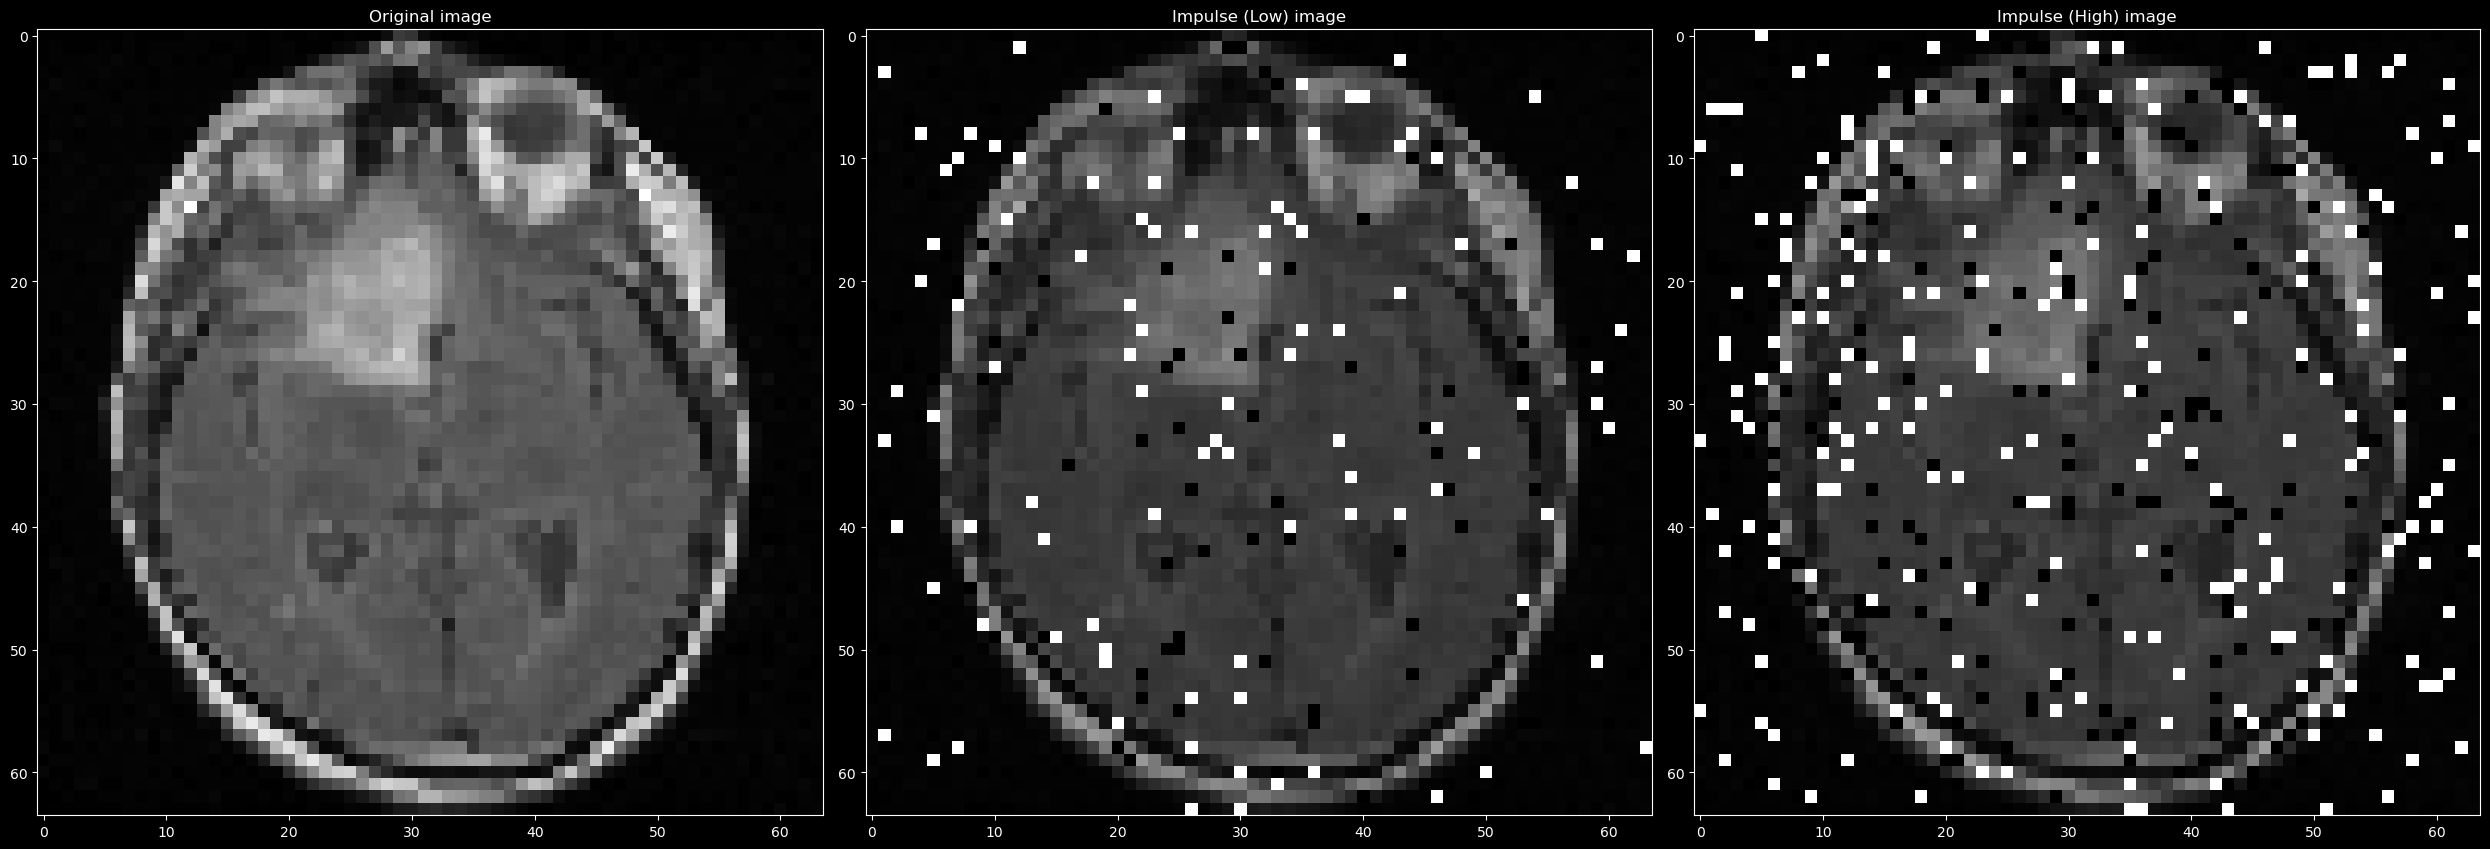

In [9]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]
fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Impulse (Low) image')
axes[1].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Impulse (High) image')
axes[2].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

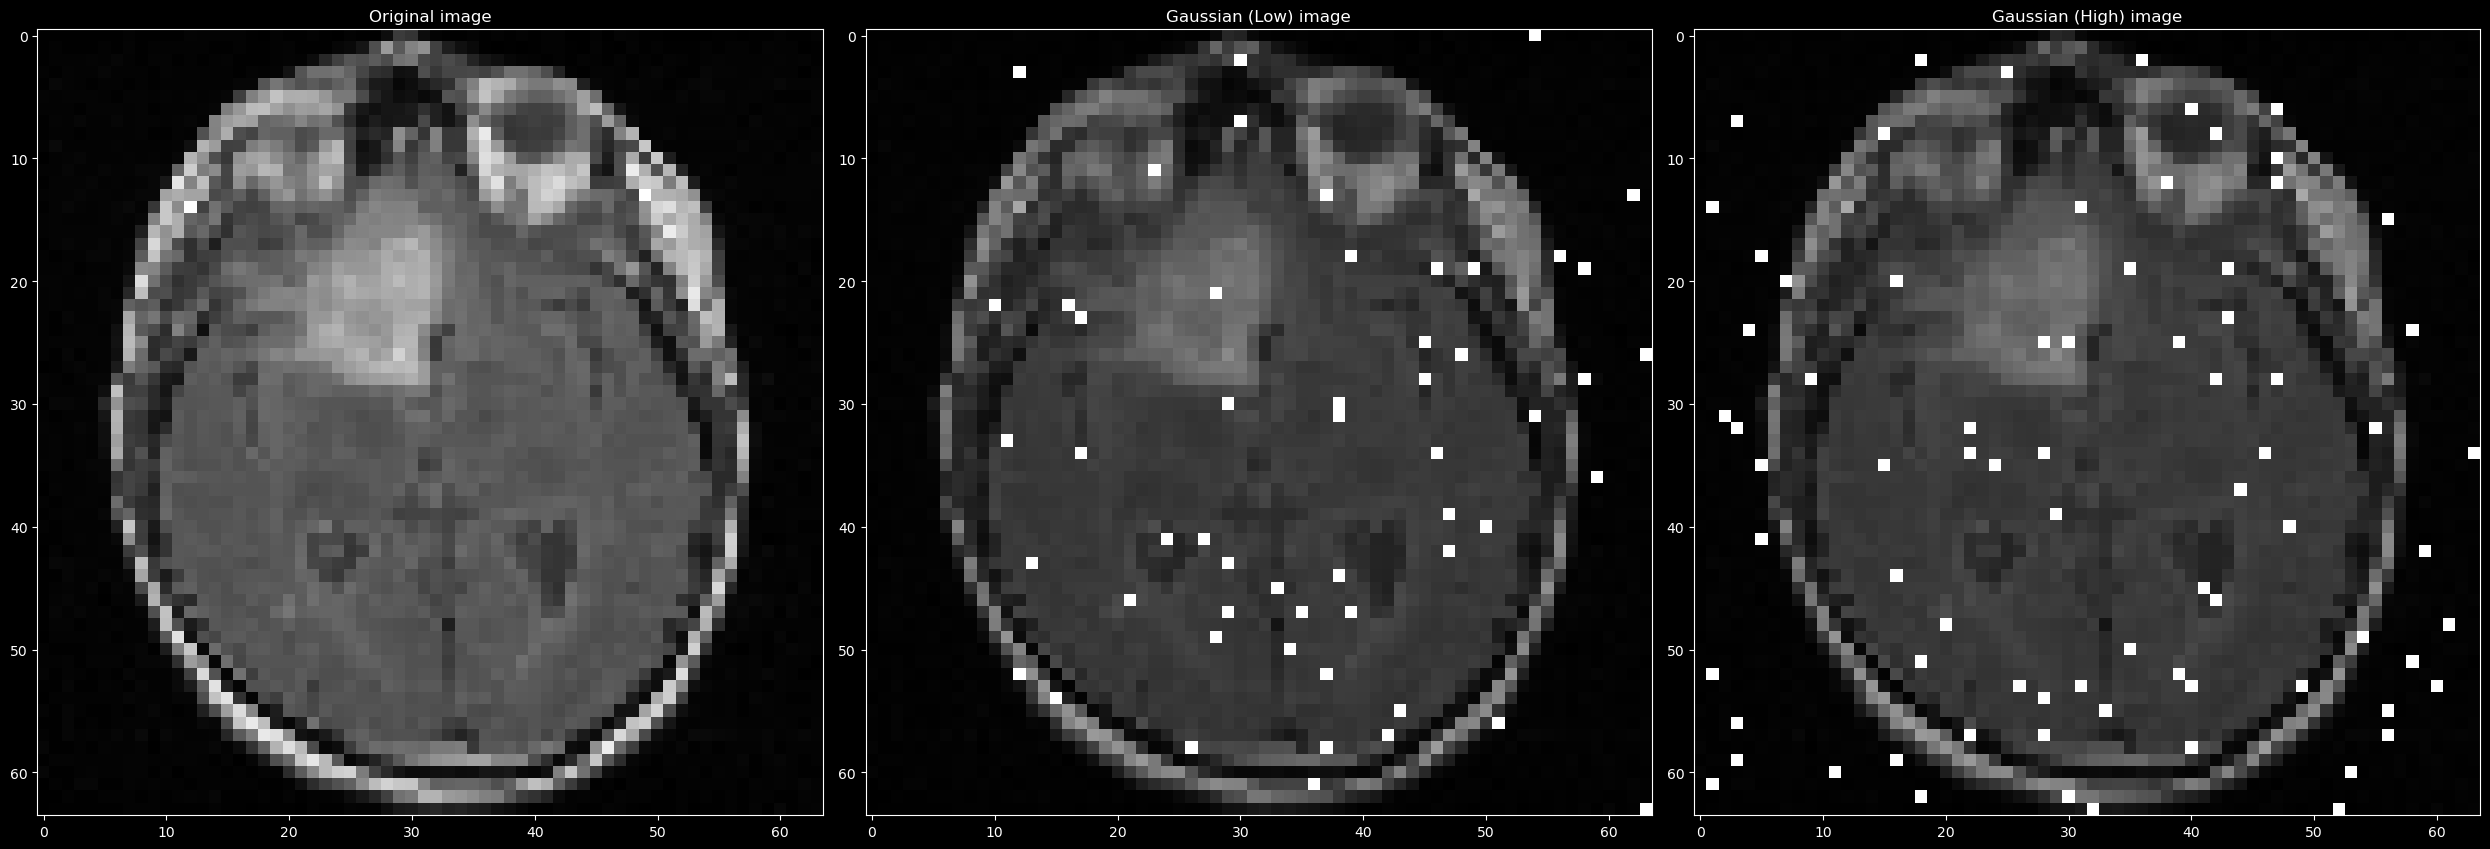

In [10]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Gaussian (Low) image')
axes[1].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_LOW_SIGMA), cmap='gray')  

axes[2].set_title('Gaussian (High) image')
axes[2].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_HIGH_SIGMA), cmap='gray')  

plt.tight_layout()  
plt.show()

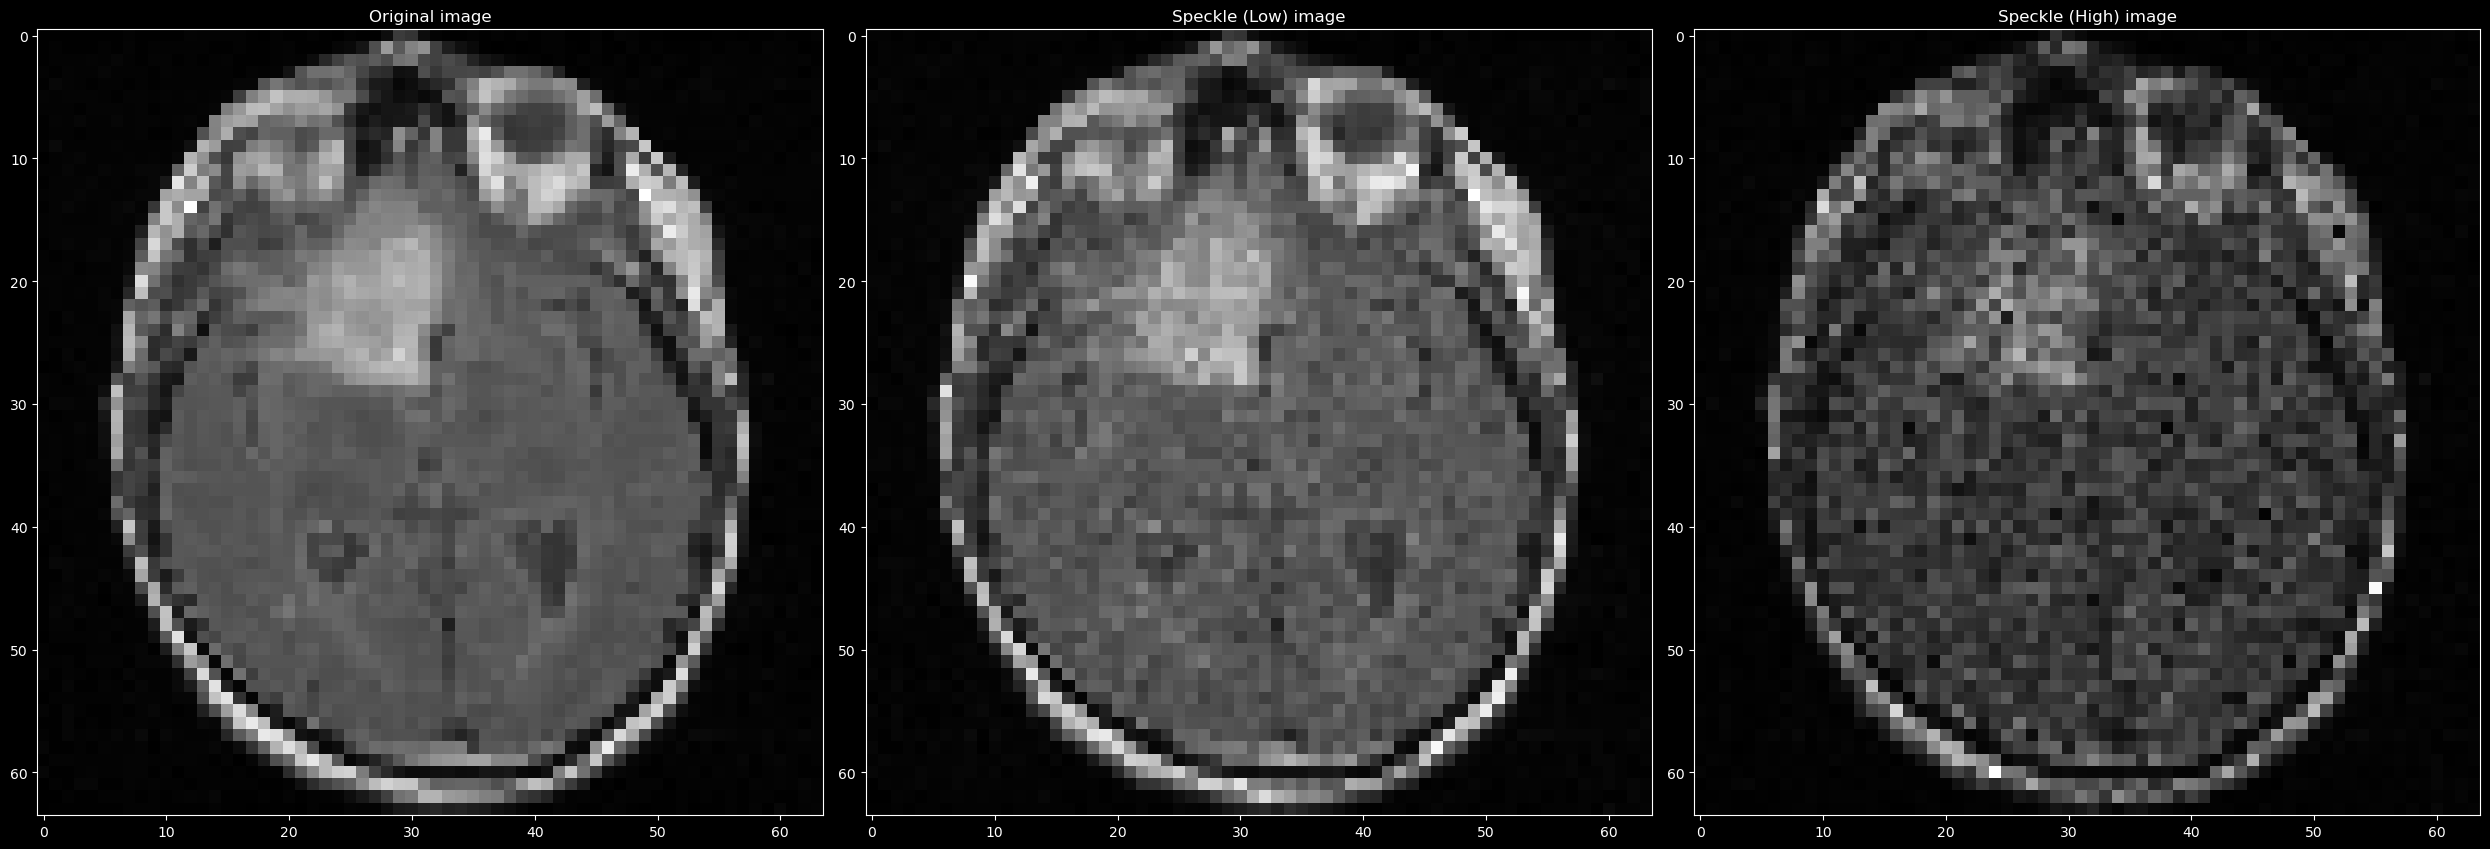

In [11]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Speckle (Low) image')
axes[1].imshow(add_speckle_noise(test_img, SPECKLE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Speckle (High) image')
axes[2].imshow(add_speckle_noise(test_img, SPECKLE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

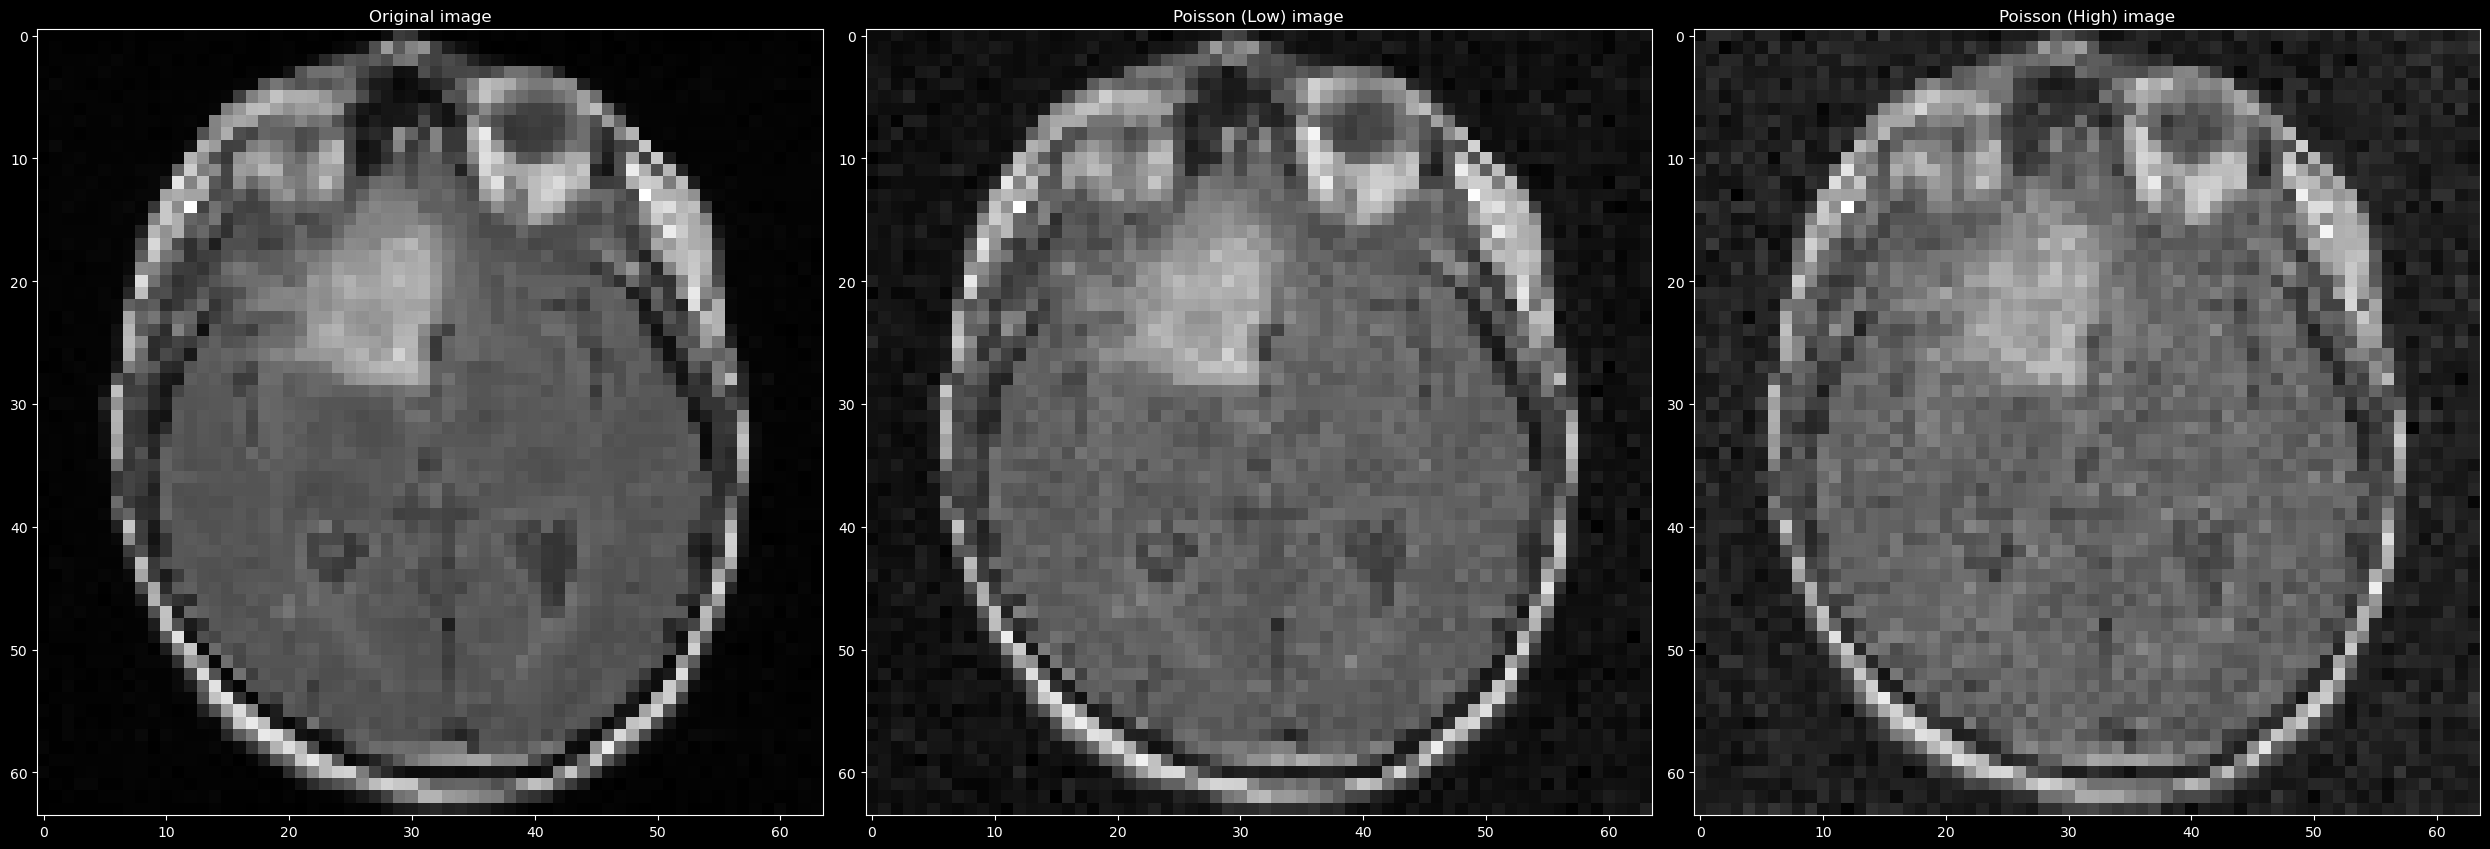

In [12]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Poisson (Low) image')
axes[1].imshow(add_poisson_noise(test_img, 2e+1), cmap='gray')  

axes[2].set_title('Poisson (High) image')
axes[2].imshow(add_poisson_noise(test_img, 70), cmap='gray')  

plt.tight_layout()  
plt.show()

In [13]:
# Image augmentation (Horizontal / Vertical flip / 45 degree rotation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)

In [14]:
x_data = []
y_data = []

def augment_and_append(original_img, noise_type):
    x_data.append(original_img)
    y_data.append(noise_type)

    for _ in range(1):  
        augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
        x_data.extend(augmented_imgs)
        y_data.extend([noise_type] * len(augmented_imgs))

# Loop through each image
for img in imgs:
    # Impulse
    for i in range(2):
        original_img = add_salt_and_pepper_noise(img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY)
        augment_and_append(original_img, NOISE_TYPE_IMPULSE)

    for i in range(2):
        original_img = add_salt_and_pepper_noise(img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY)
        augment_and_append(original_img, NOISE_TYPE_IMPULSE)

    # Gaussian
    
    for i in range(2):
        original_img = add_gaussian_noise(img, 0, GAUSSIAN_LOW_SIGMA)
        augment_and_append(original_img, NOISE_TYPE_GAUSSIAN)

    for i in range(2):
        original_img = add_gaussian_noise(img, 0, GAUSSIAN_HIGH_SIGMA)
        augment_and_append(original_img, NOISE_TYPE_GAUSSIAN)

    # Speckle
    for i in range(2):
        original_img = add_speckle_noise(img, SPECKLE_LOW_PROBABILITY)
        augment_and_append(original_img, NOISE_TYPE_SPECKLE)

    for i in range(2):
        original_img = add_speckle_noise(img, SPECKLE_HIGH_PROBABILITY)
        augment_and_append(original_img, NOISE_TYPE_SPECKLE)

    # Poisson
    for i in range(2):
        original_img = add_poisson_noise(img, 2e+1)
        augment_and_append(original_img, NOISE_TYPE_POISSON)

    for i in range(2):
        original_img = add_poisson_noise(img, 70)
        augment_and_append(original_img, NOISE_TYPE_POISSON)

In [15]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_data = np.expand_dims(x_data, axis=3) / 255.0

print('x_data len: ', len(x_data))
print('x shape: ', x_data[0].shape)
print('y_data len: ', len(y_data))

x_data len:  124736
x shape:  (64, 64, 1)
y_data len:  124736


In [16]:
# Splitting data into train, test and validation

from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=104, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=104, test_size=0.25)

In [17]:
print(x_train.shape)

(70164, 64, 64, 1)


In [18]:
print('x train len ', len(x_train))
print('x test len ', len(x_test))
print('x val len ', len(x_val))
print('x train image shape', x_train[1].shape)
print('y train len ', len(y_train))

x train len  70164
x test len  31184
x val len  23388
x train image shape (64, 64, 1)
y train len  70164


In [19]:
# Convert y data to categorical
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
#y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)

print(y_train[0])

3


In [20]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=12)

Epoch 1/50
5847/5847 [==============================] - 44s 6ms/step - loss: 0.4947 - accuracy: 0.7983 - val_loss: 0.6962 - val_accuracy: 0.7131
Epoch 2/50
5847/5847 [==============================] - 32s 5ms/step - loss: 0.3603 - accuracy: 0.8507 - val_loss: 0.4572 - val_accuracy: 0.8480
Epoch 3/50
5847/5847 [==============================] - 32s 6ms/step - loss: 0.3129 - accuracy: 0.8708 - val_loss: 0.4351 - val_accuracy: 0.8392
Epoch 4/50
5847/5847 [==============================] - 36s 6ms/step - loss: 0.2829 - accuracy: 0.8851 - val_loss: 0.3925 - val_accuracy: 0.8371
Epoch 5/50
5847/5847 [==============================] - 32s 6ms/step - loss: 0.2654 - accuracy: 0.8941 - val_loss: 0.4239 - val_accuracy: 0.8244
Epoch 6/50
5847/5847 [==============================] - 32s 5ms/step - loss: 0.2480 - accuracy: 0.9016 - val_loss: 0.3266 - val_accuracy: 0.8672
Epoch 7/50
5847/5847 [==============================] - 32s 5ms/step - loss: 0.2408 - accuracy: 0.9059 - val_loss: 0.4736 - val_ac

In [21]:
metrics = model.evaluate(x_test, y_test)
print(metrics)

975/975 [==============================] - 6s 5ms/step - loss: 0.1751 - accuracy: 0.9603
[0.17509782314300537, 0.9602680802345276]


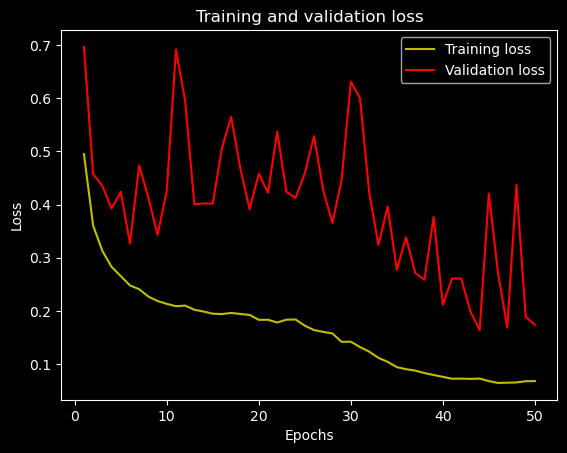

{'loss': [0.49472206830978394, 0.360257089138031, 0.3129168450832367, 0.2828724980354309, 0.2653983533382416, 0.24800731241703033, 0.24084806442260742, 0.22699904441833496, 0.2186487913131714, 0.21324411034584045, 0.20888185501098633, 0.21003150939941406, 0.20217324793338776, 0.19887134432792664, 0.19480213522911072, 0.19409506022930145, 0.19622327387332916, 0.19427268207073212, 0.19250649213790894, 0.18323829770088196, 0.18346109986305237, 0.17819632589817047, 0.18353265523910522, 0.18396338820457458, 0.17223575711250305, 0.16403858363628387, 0.16059674322605133, 0.15768395364284515, 0.1418694406747818, 0.1422242522239685, 0.13201071321964264, 0.12345799058675766, 0.11178333312273026, 0.10436142235994339, 0.0943557620048523, 0.090548574924469, 0.08781397342681885, 0.08326930552721024, 0.07959318161010742, 0.07611485570669174, 0.07256563007831573, 0.07283500581979752, 0.0722850114107132, 0.0728854089975357, 0.06811664998531342, 0.06469666957855225, 0.06512705981731415, 0.06562201678752

In [22]:
history = hist

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

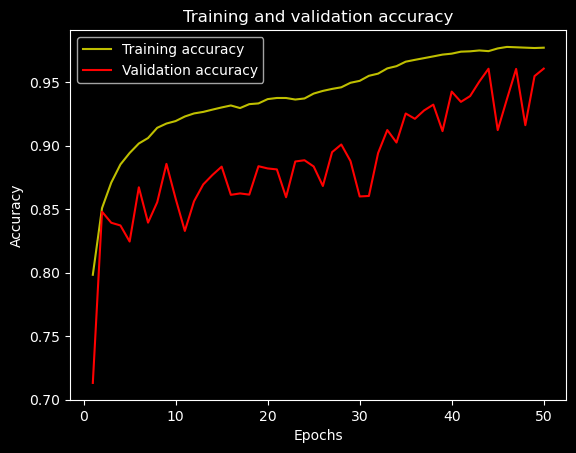

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

975/975 [==============================] - 4s 3ms/step
y pred :  1
actual noise type (index) :  1


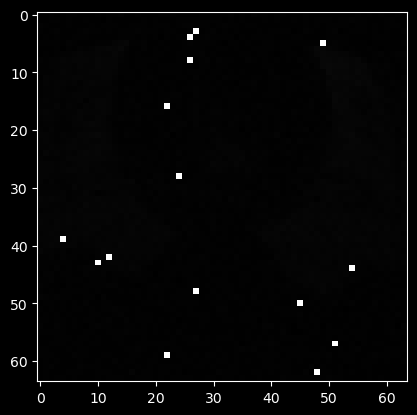

y pred :  1
actual noise type (index) :  1


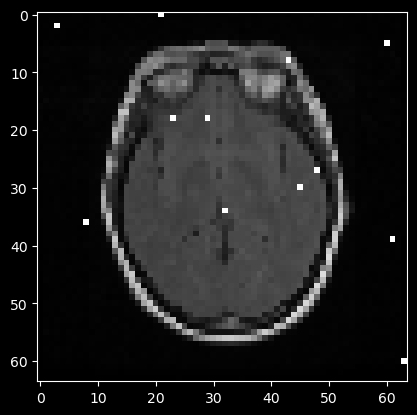

y pred :  1
actual noise type (index) :  1


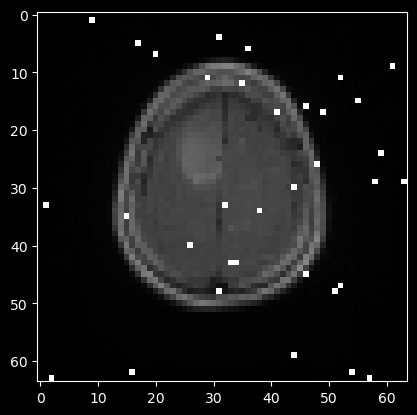

y pred :  1
actual noise type (index) :  1


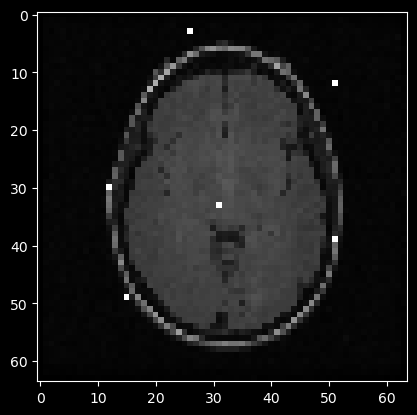

y pred :  0
actual noise type (index) :  0


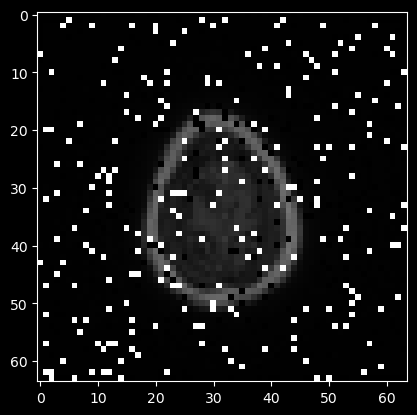

y pred :  1
actual noise type (index) :  1


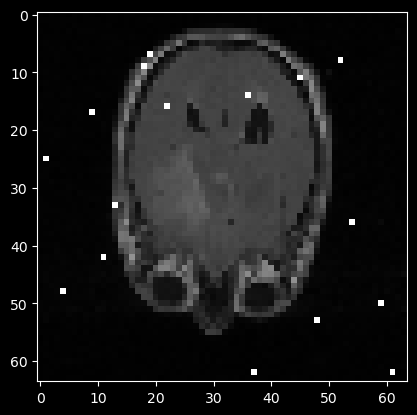

y pred :  0
actual noise type (index) :  0


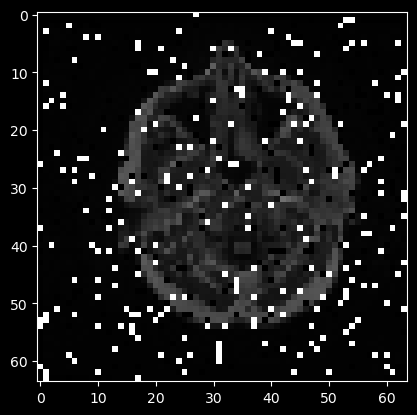

y pred :  3
actual noise type (index) :  3


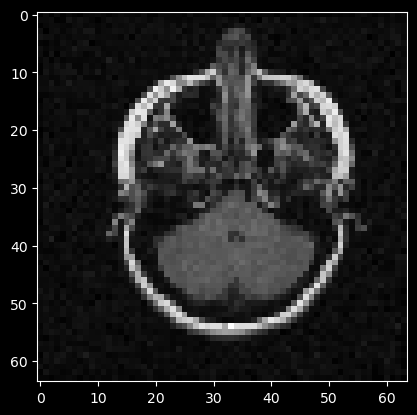

y pred :  1
actual noise type (index) :  1


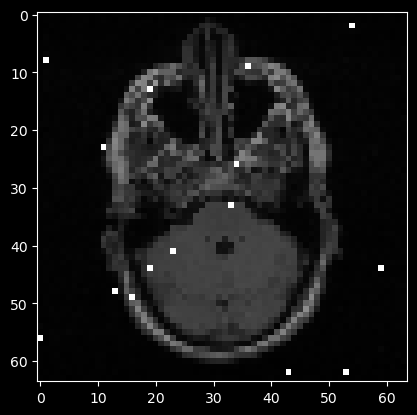

y pred :  1
actual noise type (index) :  1


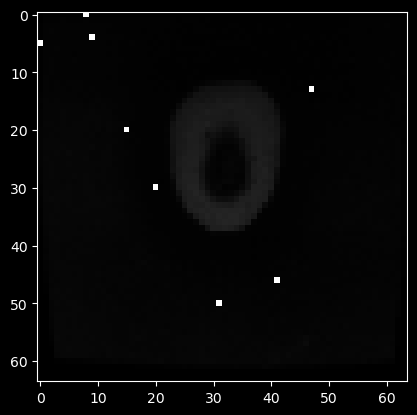

In [24]:
# Some predictions to see how the model performs.
y_pred=model.predict(x_test)

for i in range(10):
    plt.imshow(x_test[i], cmap='gray')
    print('y pred : ', np.argmax(y_pred[i]))
    print('actual noise type (index) : ', y_test[i])
    plt.show()

In [29]:
model.save('saved_noise_type_model.h5')

Test on the AAPM - Mayo Low Dose CT Grand Challenge Dataset

In [30]:

import sys
sys.path.append('../denoising-models/hformer_vit/')

from data_importer import load_training_images

noisy_images, clean_images = load_training_images('../../../../Dataset/LowDoseCTGrandChallenge/Selected_Image_Pairs/')

from model.hformer_model import PatchExtractor
patch_extractor = PatchExtractor(patch_size=64, stride=64, name="patch_extractor")
noisy_image_patches = patch_extractor(noisy_images)
clean_image_patches = patch_extractor(clean_images)


loaded training images x and y of len :  5 5  respectively
type of train images x :  float64
range of values in train images :  0.0 0.915283203125
type of train images y :  float64


In [31]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))

    # Reconstruct the image by placing each patch in its corresponding position
    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)



10/10 [==============================] - 0s 20ms/step
0.0 0.021728516


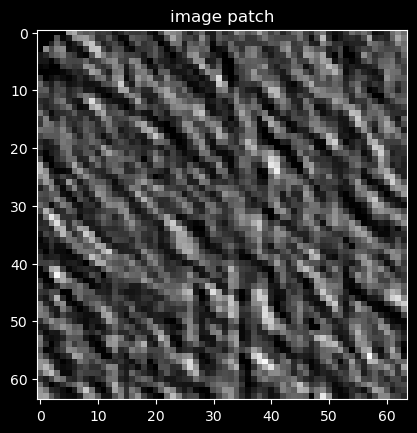

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [7.9176887e-10 4.0836283e-03 9.9591643e-01 3.5470972e-08]  classified index :  2
0.0 0.028808594


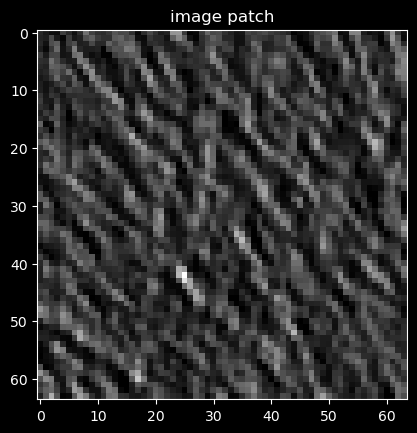

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [7.0792183e-10 3.8948504e-03 9.9610519e-01 4.4728750e-08]  classified index :  2
0.0 0.024414062


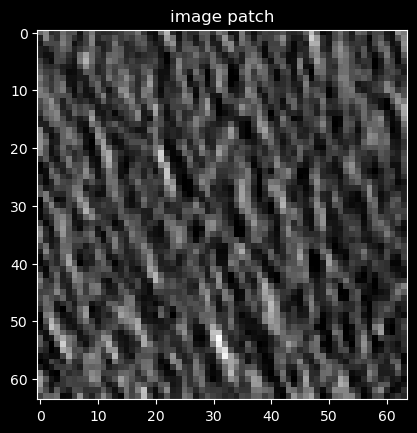

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [5.5947630e-10 4.6089464e-03 9.9539101e-01 3.0412021e-08]  classified index :  2
0.0 0.01953125


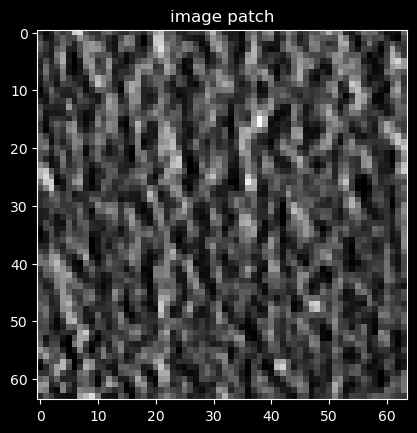

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [5.7345578e-10 5.0261007e-03 9.9497390e-01 2.7996423e-08]  classified index :  2
0.0 0.017089844


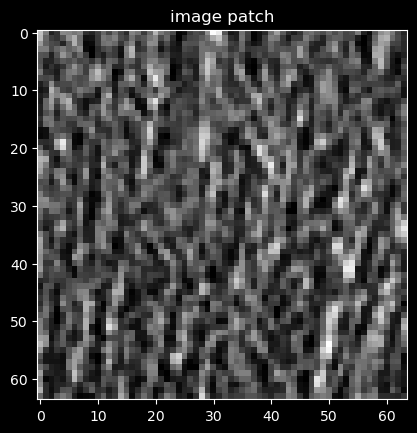

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [4.2435933e-10 3.2981327e-03 9.9670190e-01 1.6253562e-08]  classified index :  2
0.0 0.017333984


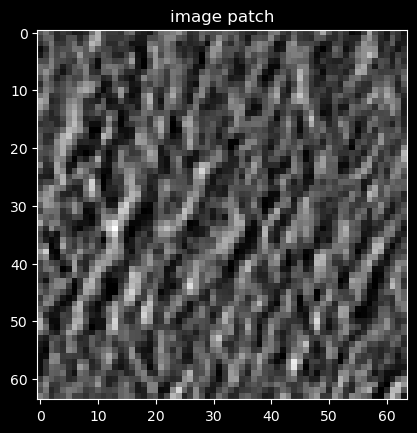

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [6.1935118e-10 3.5127483e-03 9.9648726e-01 1.7907078e-08]  classified index :  2
0.0 0.017089844


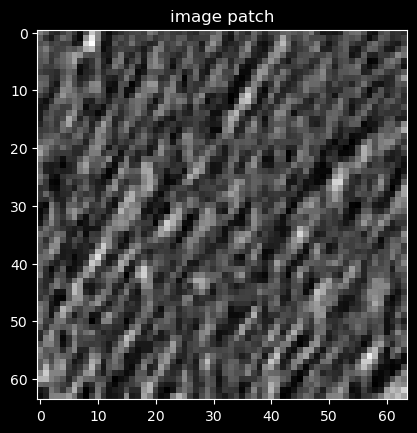

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [4.9386012e-10 3.5459271e-03 9.9645412e-01 1.4905000e-08]  classified index :  2
0.0 0.017578125


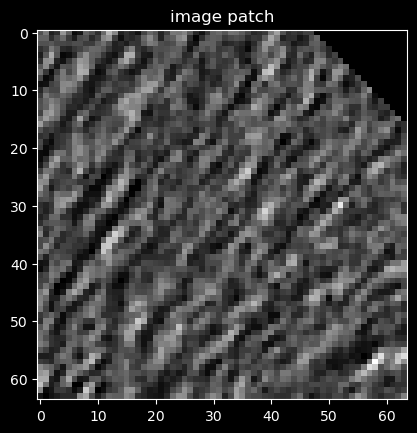

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [3.7929132e-10 2.8512338e-03 9.9714881e-01 9.2457348e-09]  classified index :  2
0.0 0.14550781


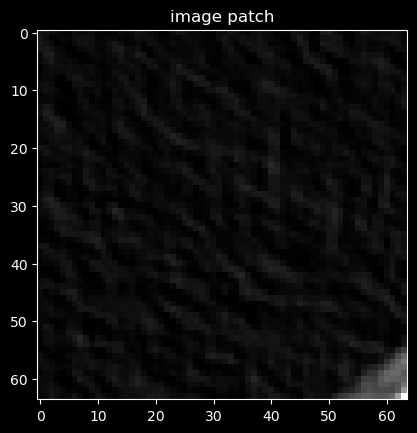

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [1.7549376e-09 8.8590933e-03 9.9114066e-01 2.8212528e-07]  classified index :  2
0.0 0.28588867


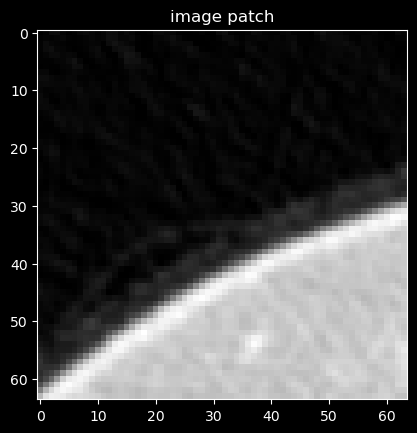

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [3.0504303e-08 9.7687119e-01 3.5673111e-06 2.3125174e-02]  classified index :  1


In [43]:
# Test of a image patch to see what the model predicts
pred = model.predict(clean_image_patches)

for i in range(0, 10):
    plt.title('image patch')
    plt.imshow(clean_image_patches[i], cmap='gray')
    print(np.min(clean_image_patches[i]), np.max(clean_image_patches[i]))
    plt.show()
    print('Noise indices : ')
    print('impulse : 0')
    print('gaussian : 1')
    print('speckle : 2')
    print('poisson : 3')


    print('identified noise type : ', pred[i], ' classified index : ', np.argmax(pred[i]))

In [39]:
# [TO verify if model is actually not able to identify type of noise]

pred = model.predict(x_test)
print(pred[0])

pred = model.predict(clean_image_patches)
print(pred[0])

975/975 [==============================] - 3s 3ms/step
[1.5688313e-07 9.9999988e-01 8.2494109e-11 1.0199362e-09]
10/10 [==============================] - 0s 3ms/step
[7.9176887e-10 4.0836283e-03 9.9591643e-01 3.5470972e-08]


10/10 [==============================] - 0s 22ms/step
0.0 0.021728516


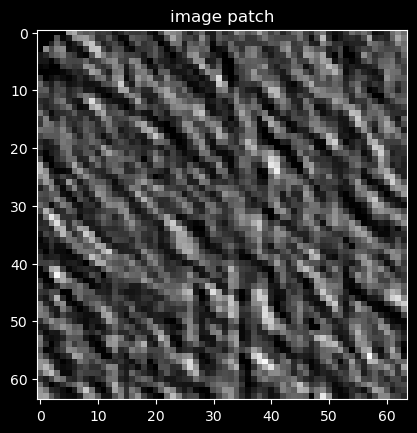

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [1.9744779e-09 8.1526265e-03 9.9184638e-01 1.1047688e-06]  classified index :  2
0.0 0.028808594


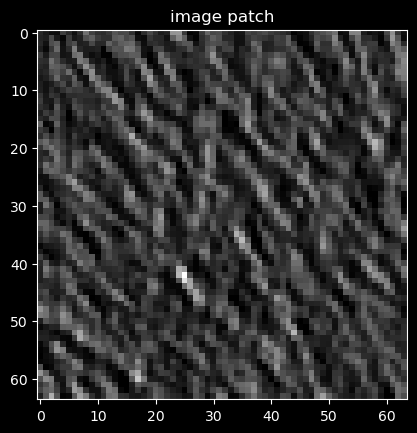

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [4.9137769e-09 1.3368693e-02 9.8663062e-01 6.7397627e-07]  classified index :  2
0.0 0.024414062


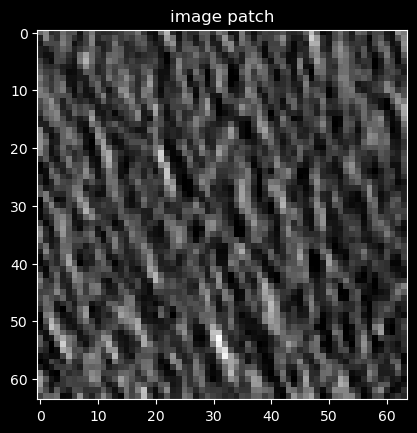

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [2.9951699e-09 9.4817933e-03 9.9051768e-01 4.1800033e-07]  classified index :  2
0.0 0.01953125


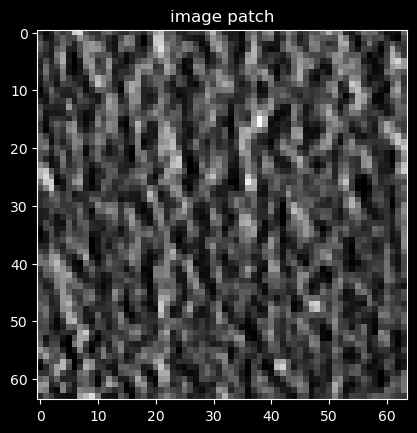

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [9.4565966e-10 7.7418378e-03 9.9225789e-01 1.8985291e-07]  classified index :  2
0.0 0.017089844


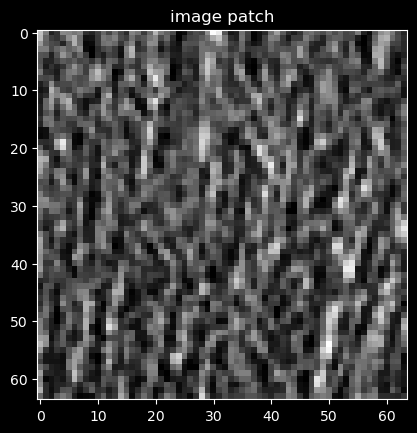

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [2.4564113e-09 1.1663610e-02 9.8833603e-01 3.4070379e-07]  classified index :  2
0.0 0.017333984


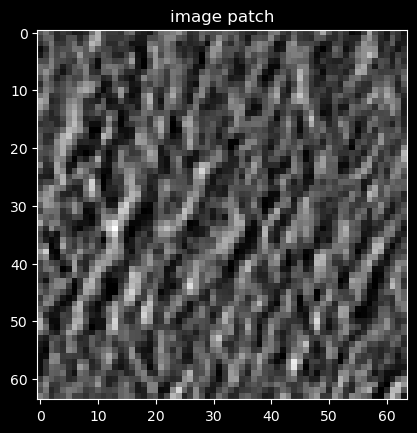

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [1.1884429e-09 8.0324188e-03 9.9196738e-01 2.1649257e-07]  classified index :  2
0.0 0.017089844


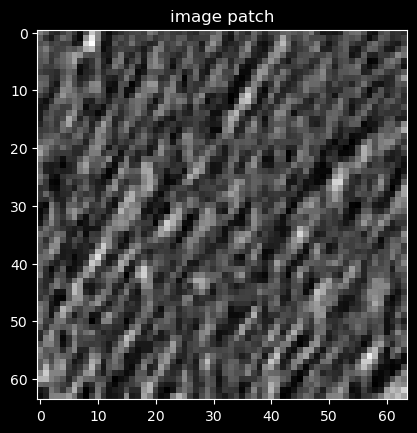

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [1.1224461e-09 8.0750464e-03 9.9192482e-01 1.1527016e-07]  classified index :  2
0.0 0.017578125


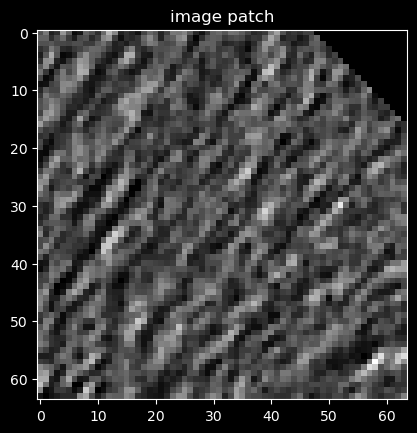

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [4.7614124e-10 3.8011631e-03 9.9619883e-01 2.6658029e-08]  classified index :  2
0.0 0.14550781


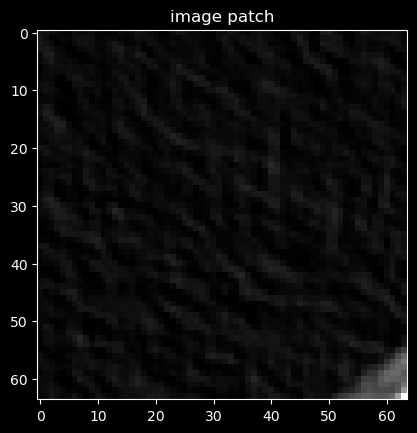

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [5.6426317e-09 2.1120157e-02 9.7887623e-01 3.5705921e-06]  classified index :  2
0.0 0.28588867


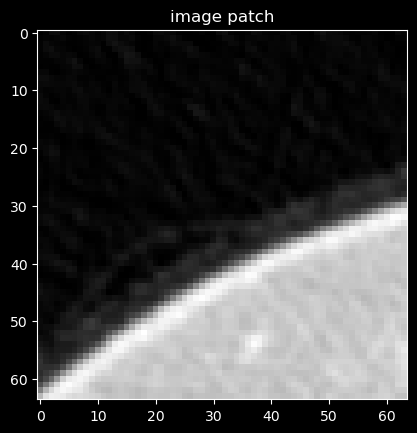

Noise indices : 
impulse : 0
gaussian : 1
speckle : 2
poisson : 3
identified noise type :  [5.3105026e-08 8.9446551e-01 3.4816237e-06 1.0553098e-01]  classified index :  1


In [44]:
# Test of a image patch to see what the model predicts
pred = model.predict(noisy_image_patches)

for i in range(0, 10):
    plt.title('image patch')
    plt.imshow(clean_image_patches[i], cmap='gray')
    print(np.min(clean_image_patches[i]), np.max(clean_image_patches[i]))
    plt.show()
    print('Noise indices : ')
    print('impulse : 0')
    print('gaussian : 1')
    print('speckle : 2')
    print('poisson : 3')


    print('identified noise type : ', pred[i], ' classified index : ', np.argmax(pred[i]))